In [1]:
from wingflattenfuncs import P2, P3
from wingflattenfuncs import WingShape
from wingflattenfuncs import loadwingtrimlinesDeprecated, trimlinestopolygons, exportpolygonsobj

import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)
# approximately flat and in metres (based around section 7) without the compression at the leading edge

No pygmsh here
Parametrization in uv:  (0, 6.11206792886613) (-1.377293405726668, 1.377293405726668)


In [4]:
import re, json

class ParamPolyGraph:
    def __init__(self, wingshape, trimfile, deprecatedTrimFile=False):
        self.legsampleleng = 0.05
        self.splineweight = 0.21
        self.wingshape = wingshape
        if deprecatedTrimFile:
            snodes, self.paths = loadwingtrimlinesDeprecated(trimfile)
            self.nodes = dict((n, self.wingshape.sevalconvO(p))  for n, p in snodes.items())  
        else:
            jdata = json.load(open(trimfile))
            self.nodes = dict((nn, P2(*p))  for nn, p in jdata["nodes"].items())
            self.paths = jdata["paths"]
        self.Inodemax = max(int(re.sub("[^\d]", "", nn) or "0")  for nn in self.nodes)
    def saveas(self, trimfile):
        json.dump({"nodes":self.nodes, "paths":self.paths}, open(trimfile, "w"))
        
    def closestnodedist(self, mp):
        return min(((mp - p).Len(), nn)  for nn, p in self.nodes.items())
    def pointsdata(self):
        return zip(*self.nodes.values())
    def legsdata(self):
        return [[self.nodes[self.paths[i]], self.nodes[self.paths[i+1]]]  for i in range(0, len(self.paths), 2)]
    def commitlineedit(self, n1, n2):
        for i in range(0, len(self.paths), 2):
            if (n1 == self.paths[i] and n2 == self.paths[i+1]) or (n1 == self.paths[i+1] and n2 == self.paths[i]):
                del self.paths[i:i+2]
                return
        self.paths.extend([n1, n2])
    def delnode(self, n1):
        for i in range(0, len(self.paths), 2):
            while i < len(self.paths) and (n1 == self.paths[i] or n1 == self.paths[i+1]):
                del self.paths[i:i+2]
        del self.nodes[n1]
    def newnode(self, n1, mp):
        n2 = None
        while n2 is None or n2 in self.nodes:
            self.Inodemax += 1
            n2 = "i%d" % self.Inodemax
        self.nodes[n2] = mp
        self.paths.extend([n1, n2])
        return n2
        
    def tangentvec(self, n1, n2):
        vn = P2.ZNorm(self.nodes[n2] - self.nodes[n1])
        if len(self.neighbournodes[n1]) == 2 and not self.wingshape.uvonboundary(self.nodes[n1]):
            i = self.neighbournodes[n1].index(n2)
            nb = self.neighbournodes[n1][1-i]
            vb = P2.ZNorm(self.nodes[n1] - self.nodes[nb])
            vn = P2.ZNorm(vn + vb)
        return vn

    def splineinterpseqq(self, n0, n1):
        p0 = self.nodes[n0]
        p1 = self.nodes[n1]
        sleg = [ p0 ]
        m0 = self.tangentvec(n0, n1)*self.splineweight
        m1 = -self.tangentvec(n1, n0)*self.splineweight
        N = max(1, int((p0 - p1).Len()/self.legsampleleng + 0.75))
        for i in range(1, N):
            t = i*1.0/N
            t2 = t*t
            t3 = t2*t
            p = p0*(2*t3 - 3*t2 +1) + m0*(t3 - 2*t2 + t) + p1*(-2*t3 + 3*t2) + m1*(t3 - t2)
            sleg.append(p)
        sleg.append(p1)
        return sleg
    
    def splineinterplegsdata(self):
        self.neighbournodes = dict((nn, [])  for nn in self.nodes)
        for i in range(0, len(self.paths), 2):
            self.neighbournodes[self.paths[i]].append(self.paths[i+1])
            self.neighbournodes[self.paths[i+1]].append(self.paths[i])
        return [ self.splineinterpseqq(self.paths[i], self.paths[i+1])  for i in range(0, len(self.paths), 2) ]

    
parapolygraph = ParamPolyGraph(wingshape, "segmentedwing.txt", deprecatedTrimFile=True)
parapolygraph.saveas("test.json")
parapolygraph = ParamPolyGraph(wingshape, "test.json")


<IPython.core.display.Javascript object>


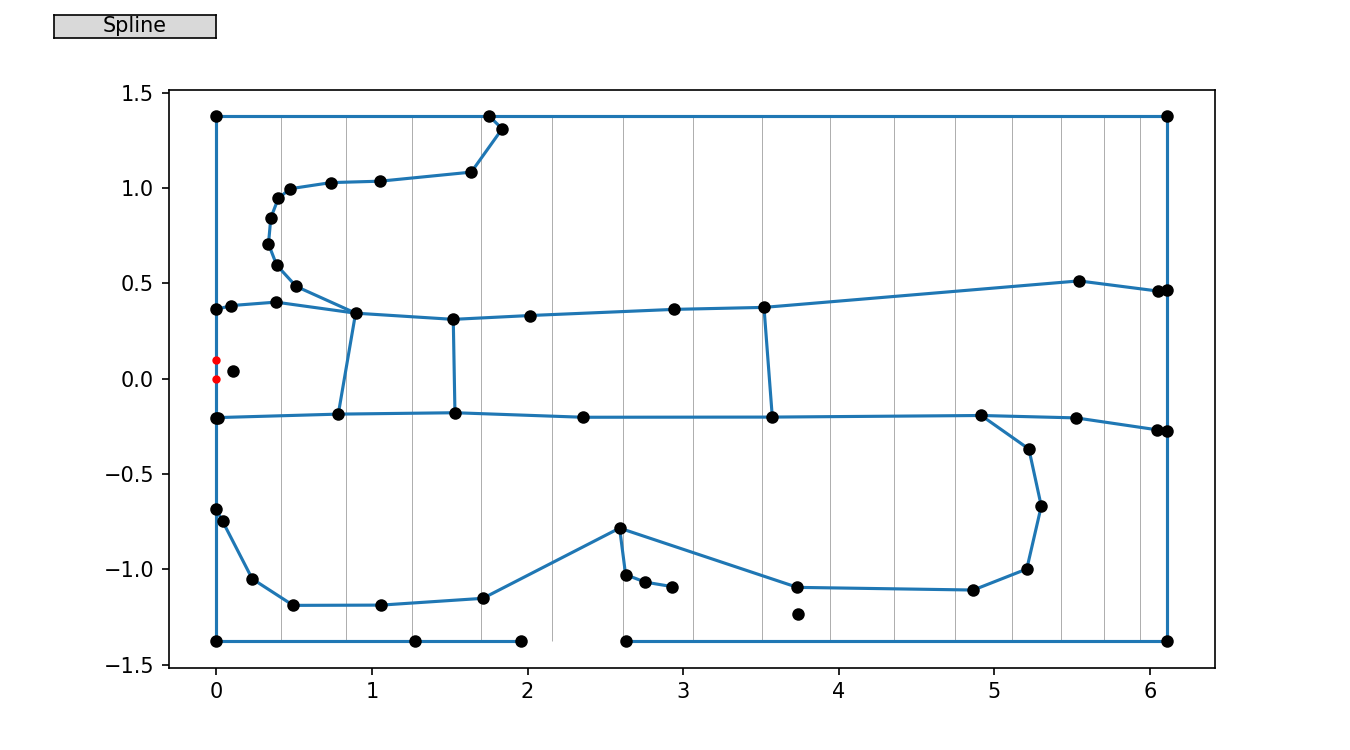

In [5]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from matplotlib.widgets import Button

cursor1, cursor2 = None, None
def cursordata():
    return zip(*[cursor1 or P2(0,0), cursor2 or P2(0,0.1)])

fig = plt.figure(figsize=(9,5))
axpara = fig.add_subplot(1,1,1)
axpara.add_collection(mc.LineCollection([[(u, wingshape.vrange[0]), (u, wingshape.vrange[1])]  for u in wingshape.leadingedgelengths ], color="grey", linewidth=0.3))

lupdater = axpara.add_collection(mc.LineCollection(parapolygraph.legsdata()))
mupdater, = axpara.plot(*parapolygraph.pointsdata(), color='black', linestyle='none', marker='o', markersize=5)
cursorupdater, = axpara.plot(*cursordata(), color='red', linestyle='none', marker='o', markersize=3)

axpara.autoscale()

events = [ ]
nodenamedown = None
nodeclickdistance = 0.04
Dlineedits = [ ]

def button_press_callback(event):
    global nodenamedown, cursor1, cursor2
    if event.inaxes == axpara:
        mp = wingshape.clampuv(P2(event.xdata, event.ydata))
        l, nn = parapolygraph.closestnodedist(mp)
        if cursor2 is not None:
            if l < nodeclickdistance:
                if nodenamedown == nn:
                    parapolygraph.delnode(nodenamedown)
                nodenamedown = None
                cursor2 = None
            elif nodenamedown is not None:
                nodenamedown = parapolygraph.newnode(nodenamedown, mp)
                Dlineedits.append(("newnode", nodenamedown))
                cursor2 = mp
            mupdater.set_data(parapolygraph.pointsdata())
            lupdater.set_segments(parapolygraph.legsdata())
        elif l < nodeclickdistance:
            if event.button == 1:
                nodenamedown = nn
                cursor1 = None
            elif event.button == 3:
                nodenamedown = nn
                cursor2 = parapolygraph.nodes[nodenamedown]
        cursorupdater.set_data(cursordata())
        fig.canvas.draw_idle()

def button_release_callback(event):
    global nodenamedown, cursor2
    events.append(event)
    if nodenamedown is not None:
        if cursor2 is not None and event.button == 3 and nodenamedown is not None and cursor1 is not None:
            l, nn = parapolygraph.closestnodedist(cursor1)
            if l < nodeclickdistance and nodenamedown != nn:
                parapolygraph.commitlineedit(nodenamedown, nn)
                lupdater.set_segments(parapolygraph.legsdata())
            nodenamedown = None
            cursor2 = None
        elif event.button == 1 and cursor2 is None:
            nodenamedown = None
        cursorupdater.set_data(cursordata())
        fig.canvas.draw_idle()

        
def motion_notify_callback(event):
    global cursor1
    if event.inaxes == axpara:
        mp = wingshape.clampuv(P2(event.xdata, event.ydata))
        if nodenamedown is not None and cursor2 is None:
            parapolygraph.nodes[nodenamedown] = mp
            mupdater.set_data(parapolygraph.pointsdata())
            lupdater.set_segments(parapolygraph.legsdata())
            fig.canvas.draw_idle()
        else:
            cursor1 = mp
            cursorupdater.set_data(cursordata())
            fig.canvas.draw_idle()

        
def buttonSpline(event):
    lupdater.set_segments(parapolygraph.splineinterplegsdata())
    fig.canvas.draw_idle()

def key_press_callback(event):
    events.append(event)
    
axres = plt.axes([0.04, 0.95, 0.12, 0.03])
bres = Button(axres, 'Spline')
bres.on_clicked(buttonSpline)
fig.canvas.mpl_connect('button_press_event', button_press_callback)
fig.canvas.mpl_connect('button_release_event', button_release_callback)
fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)
fig.canvas.mpl_connect('key_press_event', key_press_callback)

plt.show()

In [22]:
parapolygraph.saveas("test.json")


In [ ]:
def exchyz(p):
    return (p[0], p[2], p[1])
def points3ddata():
    res = [ ]
    for p in rnodes.values():
        res.append(exchyz(wingshape.seval((-p[1], p[0]))))
    return zip(*res)
def legs3ddata(step=0.25):
    res = [ ]
    for i in range(0, len(paths), 2):
        p0, p1 = rnodes[paths[i]], rnodes[paths[i+1]]
        n = max(1, int(math.ceil((p0 - p1).Len()/step)))
        p = wingshape.seval((-p0[1], p0[0]))
        for i in range(n):
            l = (i+1.0)/n
            pn = p0*(1-l) + p1*l
            pd = wingshape.seval((-pn[1], pn[0]))
            res.append([exchyz(p), exchyz(pd)])
            p = pd
    return res


In [4]:
events